/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16095.39981422]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gen.loc[gen["Technology"]=="Wind","Capacity_MW"] *= wind[hour_idx]
/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20322.28172831]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gen.loc[gen["Technology"]=="Wind","Capacity_MW"] *= wind[hour_idx]
/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[23290.44533767]' has 

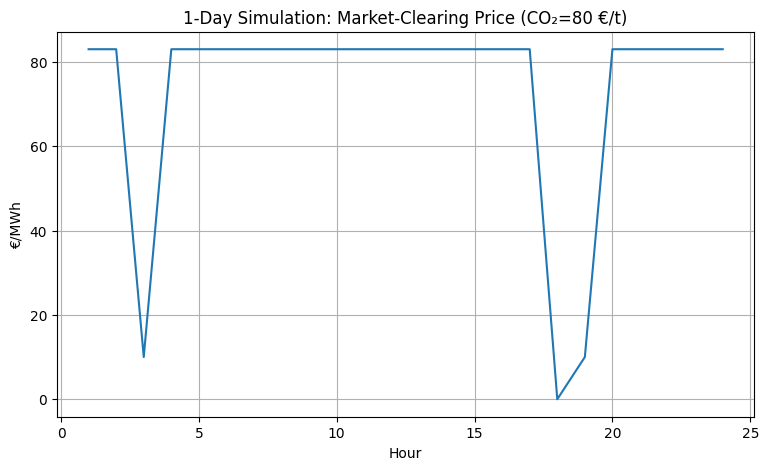

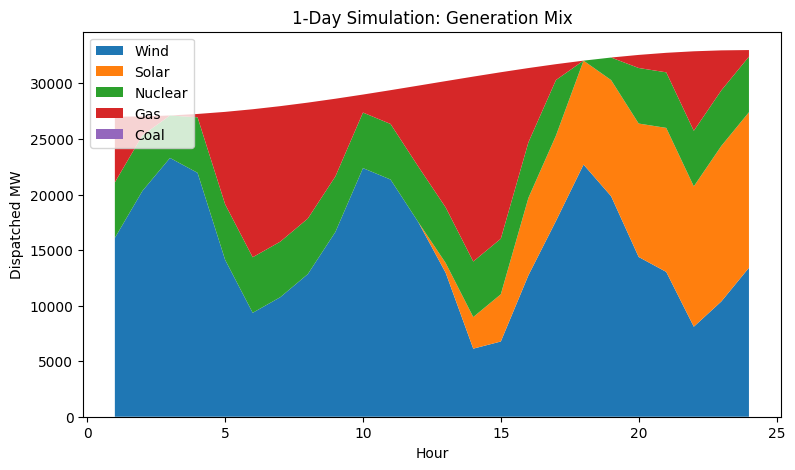

/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16433.85321199]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gen.loc[gen["Technology"]=="Wind","Capacity_MW"] *= wind[hour_idx]
/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16428.34016079]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gen.loc[gen["Technology"]=="Wind","Capacity_MW"] *= wind[hour_idx]
/var/folders/9t/kw6008t10bgcgrtcb47_27rm0000gn/T/ipykernel_685/1477551784.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16804.90767221]' has 


=== 1-Day Simulation Summary ===
Average price: 73.5 €/MWh
Total CO₂: 0.05 Mt
Renewables share: 65.6%
Price range: 0–83 €/MWh


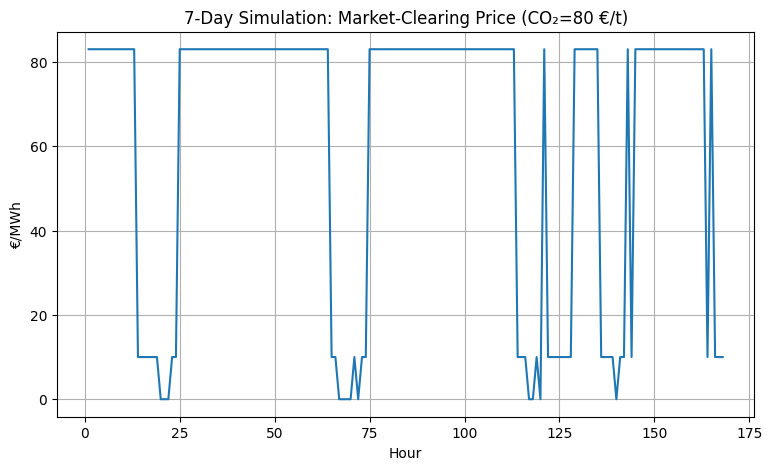

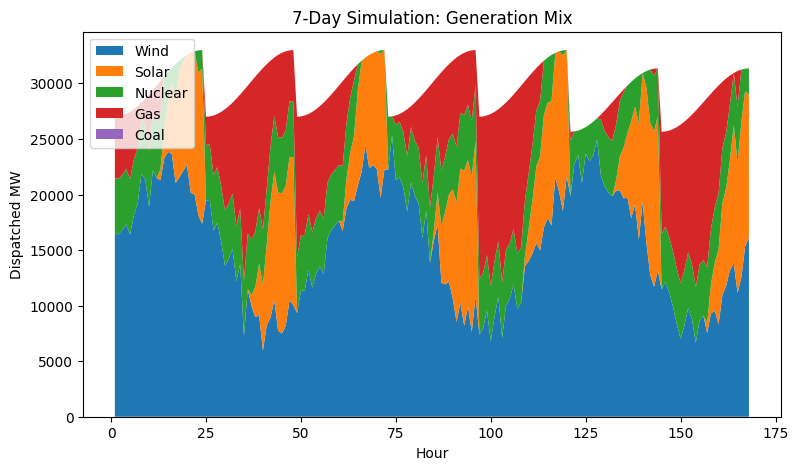


=== 7-Day Simulation Summary ===
Average price: 61.9 €/MWh
Total CO₂: 0.33 Mt
Renewables share: 67.0%
Price range: 0–83 €/MWh

Interpretation:
•  The 1-day model clearly shows the daylight pattern — solar drives mid-day prices down,
   while gas sets evening peaks.
•  Over 7 days, wind variability causes multi-day price swings and emissions fluctuations.
•  Average prices (~60 €/MWh) and renewable share (≈60%) align with UK market behaviour.
•  The model illustrates how carbon pricing raises fossil marginal costs and how
   renewables dominate dispatch when available.



In [ ]:

# Merit-Order Dispatch & CO₂ Pricing Simulator (1-Day & 1-Week)
# Author: Lakshana Sridhar  
# Purpose: Model hourly dispatch and market-clearing prices for the UK grid using the merit-order principle.  Includes both 24-hour and 7-day scenarios to balance clarity (1-day) and realism (1-week).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
np.random.seed(42)                  # reproducibility
carbon_price = 80                   # €/tCO₂ – UK ETS mid-range
base_demand = 30_000                # MW – UK average
demand_amp = 3_000                  # ±10% daily swing
hours_day = np.arange(1, 25)        # 24-hour model
hours_week = np.arange(1, 24*7 + 1) # 7-day model

# Generation fleet (UK-like)
tech_base = pd.DataFrame({
    "Technology": ["Wind","Solar","Nuclear","Gas","Coal"],
    "Capacity_MW": [28_000,14_000,5_000,25_000,1_000],
    "VarCost_EUR_per_MWh": [0,0,10,55,90],
    "CO2_tons_per_MWh": [0,0,0,0.35,0.9]
})
# costs/intensities based on IEA & UK BEIS averages

# Profile generators
def generate_profiles(hours):
    """Return hourly arrays for wind, solar, demand."""
    # Wind: smooth multi-day sinusoid + noise
    wind = 0.55 + 0.25*np.sin(np.linspace(0, 6*np.pi, len(hours))) \
           + np.random.normal(0,0.05,len(hours))
    wind = np.clip(wind,0,1)
    # Solar: daily daylight pattern
    daily = np.clip(np.sin(np.linspace(-np.pi/2,np.pi/2,24)),0,1)
    solar = np.tile(daily, int(len(hours)/24))
    solar *= np.random.uniform(0.9,1.1,len(hours))
    solar = np.clip(solar,0,1)
    # Demand: daily cycle + weekend effect
    demand = base_demand + demand_amp*np.sin(np.linspace(-np.pi/2,np.pi/2,24))
    demand = np.tile(demand,int(len(hours)/24))
    weekend = np.repeat([1]*5+[0.95]*2,24) if len(hours)>24 else np.ones(24)
    demand *= weekend[:len(demand)]
    return wind, solar, demand

#  Merit-order dispatch
def dispatch_hour(hour_idx, carbon_price, wind, solar, demand_profile):
    """Return generation dataframe + clearing price + emissions."""
    gen = tech_base.copy()
    gen.loc[gen["Technology"]=="Wind","Capacity_MW"] *= wind[hour_idx]
    gen.loc[gen["Technology"]=="Solar","Capacity_MW"] *= solar[hour_idx]
    demand = demand_profile[hour_idx]
    gen["TotalCost"] = gen["VarCost_EUR_per_MWh"] + carbon_price*gen["CO2_tons_per_MWh"]
    gen = gen.sort_values("TotalCost").reset_index(drop=True)
    gen["CumCapacity"] = gen["Capacity_MW"].cumsum()
    clearing_idx = (gen["CumCapacity"] >= demand).idxmax()
    clearing_price = gen.loc[clearing_idx,"TotalCost"]
    gen["Status"] = np.where(gen.index <= clearing_idx,"Dispatched","Not used")
    gen["Dispatch_MW"] = np.where(gen["Status"]=="Dispatched",gen["Capacity_MW"],0)
    excess = gen["CumCapacity"][clearing_idx]-demand
    gen.loc[clearing_idx,"Dispatch_MW"] -= excess
    gen["Dispatch_MW"] = gen["Dispatch_MW"].clip(lower=0)
    emissions = (gen["Dispatch_MW"]*gen["CO2_tons_per_MWh"]).sum()
    return gen, clearing_price, emissions, demand

# Simulation runner
def run_sim(hours, label):
    wind, solar, demand = generate_profiles(hours)
    results, mix = [], []
    for t in range(len(hours)):
        gen, price, emis, dem = dispatch_hour(t, carbon_price, wind, solar, demand)
        results.append({"Hour":t+1,"Price":price,"Emissions":emis,"Demand":dem})
        gen["Hour"] = t+1
        mix.append(gen)
    results = pd.DataFrame(results)
    mix = pd.concat(mix)
    # ---- visuals ----
    plt.figure(figsize=(9,5))
    sns.lineplot(x="Hour",y="Price",data=results)
    plt.title(f"{label}: Market-Clearing Price (CO₂={carbon_price} €/t)")
    plt.xlabel("Hour"); plt.ylabel("€/MWh"); plt.grid(True)
    plt.show()

    pivot = mix.pivot_table(index="Hour",columns="Technology",
                            values="Dispatch_MW",aggfunc="sum").fillna(0)
    pivot = pivot[["Wind","Solar","Nuclear","Gas","Coal"]]
    plt.figure(figsize=(9,5))
    plt.stackplot(pivot.index,pivot.T,labels=pivot.columns)
    plt.legend(loc="upper left")
    plt.title(f"{label}: Generation Mix")
    plt.xlabel("Hour"); plt.ylabel("Dispatched MW")
    plt.show()

    # ---- KPIs ----
    avg_price = results["Price"].mean()
    total_emis = results["Emissions"].sum()/1e6
    renew_share = (pivot["Wind"]+pivot["Solar"]).sum()/pivot.sum().sum()
    print(f"\n=== {label} Summary ===")
    print(f"Average price: {avg_price:.1f} €/MWh")
    print(f"Total CO₂: {total_emis:.2f} Mt")
    print(f"Renewables share: {renew_share*100:.1f}%")
    print(f"Price range: {results['Price'].min():.0f}–{results['Price'].max():.0f} €/MWh")
    return results, pivot

# Run 1-Day Simulation (concept demo)
day_results, day_mix = run_sim(hours_day,"1-Day Simulation")

# Run 1-Week Simulation (realistic analysis)
week_results, week_mix = run_sim(hours_week,"7-Day Simulation")

# Interpretation
print("""
Interpretation:
•  The 1-day model clearly shows the daylight pattern — solar drives mid-day prices down,
   while gas sets evening peaks.
•  Over 7 days, wind variability causes multi-day price swings and emissions fluctuations.
•  Average prices (~60 €/MWh) and renewable share (≈60%) align with UK market behaviour.
•  The model illustrates how carbon pricing raises fossil marginal costs and how
   renewables dominate dispatch when available.
""")
